# Product Demo
This notebook combines the efforts of this project into one. That is, this notebook will illustrate neighbor detection and apply anomaly detection and behavior detection to it

In [1]:
# imports
import os
from config_trAISformer import Config
import torch
import numpy as np
import pandas as pd
import pickle
from typing import List, Tuple, Dict, Any
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sktime.classification.deep_learning import GRUFCNNClassifier
from find_neighbors import find_neighbors_for_target
from models import TrAISformer
from trainers import sample


Using device: cpu


In [2]:
# device configuration
cf = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
data_path = cf.testset_name
with open(data_path, 'rb') as f:
    data: list[dict] = pickle.load(f)
print(f"Loaded {len(data)} samples from {data_path}")


Loaded 13828 samples from /home/chucey/GQP/TrAISformer/data/US_data/cleaned_data/traisformer_training_data/us_continent_2024_test_track.pkl


The data is a list of sictionaries in the format:
```python
[
    {
        'mmsi': type(int),
        'traj': type(np.ndarray) # of shape (timesteps, 11)
    }
]
```
The column headings of the array are : `[LAT, LON, SOG, COG, HEADING, TIMESTAMP, MMSI, SHIPTYPE, LENGTH, WIDTH, CARGO]`

Only the first four are needed for use with the trAISformer

In [4]:
# an example of the loaded data
data[0]

{'mmsi': 368062150,
 'traj': array([[2.34621500e-01, 6.51124100e-01, 0.00000000e+00, 8.01111111e-01,
         5.11000000e+02, 1.70897194e+09, 3.68062150e+08, 3.10000000e+01,
         9.00000000e+00, 6.00000000e+00, 3.10000000e+01],
        [2.34619889e-01, 6.51124156e-01, 0.00000000e+00, 8.01111111e-01,
         5.11000000e+02, 1.70897254e+09, 3.68062150e+08, 3.10000000e+01,
         9.00000000e+00, 6.00000000e+00, 3.10000000e+01],
        [2.34620500e-01, 6.51124187e-01, 0.00000000e+00, 8.01111111e-01,
         5.11000000e+02, 1.70897314e+09, 3.68062150e+08, 3.10000000e+01,
         9.00000000e+00, 6.00000000e+00, 3.10000000e+01],
        [2.34620275e-01, 6.51124393e-01, 0.00000000e+00, 8.34166667e-01,
         5.11000000e+02, 1.70897374e+09, 3.68062150e+08, 3.10000000e+01,
         9.00000000e+00, 6.00000000e+00, 3.10000000e+01],
        [2.34614696e-01, 6.51124759e-01, 3.99033816e-02, 5.39154589e-01,
         5.11000000e+02, 1.70897434e+09, 3.68062150e+08, 3.10000000e+01,
         9

## 1 The trAISformer
This model is used to predict the future positions of vessels

In [5]:
# load the trained trAISformer model

# cf.lat_size = 8000 #250 for Danish data
# cf.lon_size = 20000  #270 for Danish data
# cf.sog_size = 60 #30
# cf.cog_size = 360 #72

# cf.n_lat_embd = 256
# cf.n_lon_embd = 256
# cf.n_sog_embd = 128
# cf.n_cog_embd = 128

# cf.n_head = 8
# cf.n_layer = 8

# cf.init_seqlen = 36
# cf.max_seqlen = 96

traisformer_model_path = '/home/chucey/GQP/TrAISformer/results/us_continent_2024-pos-pos_vicinity-10-40-blur-True-False-2-1.0-data_size-8000-20000-60-360-embd_size-256-256-128-128-head-8-8-bs-32-lr-0.0006-seqlen-36-96-epochs-50/model.pt'

traisformer = TrAISformer(cf, partition_model=None)
traisformer.load_state_dict(torch.load(traisformer_model_path, map_location=device))

<All keys matched successfully>

In [6]:
# prepare the data for inference
def prepare_traisformer_input(data: np.ndarray, device=device):
    tensor = torch.tensor(data[:, :4], dtype=torch.float32).unsqueeze(0).to(device)  # add batch dimension
    return tensor


In [7]:
tensor = prepare_traisformer_input(data[0]['traj'], device)
tensor.shape  # should be (1, seq_len, 4)

torch.Size([1, 46, 4])

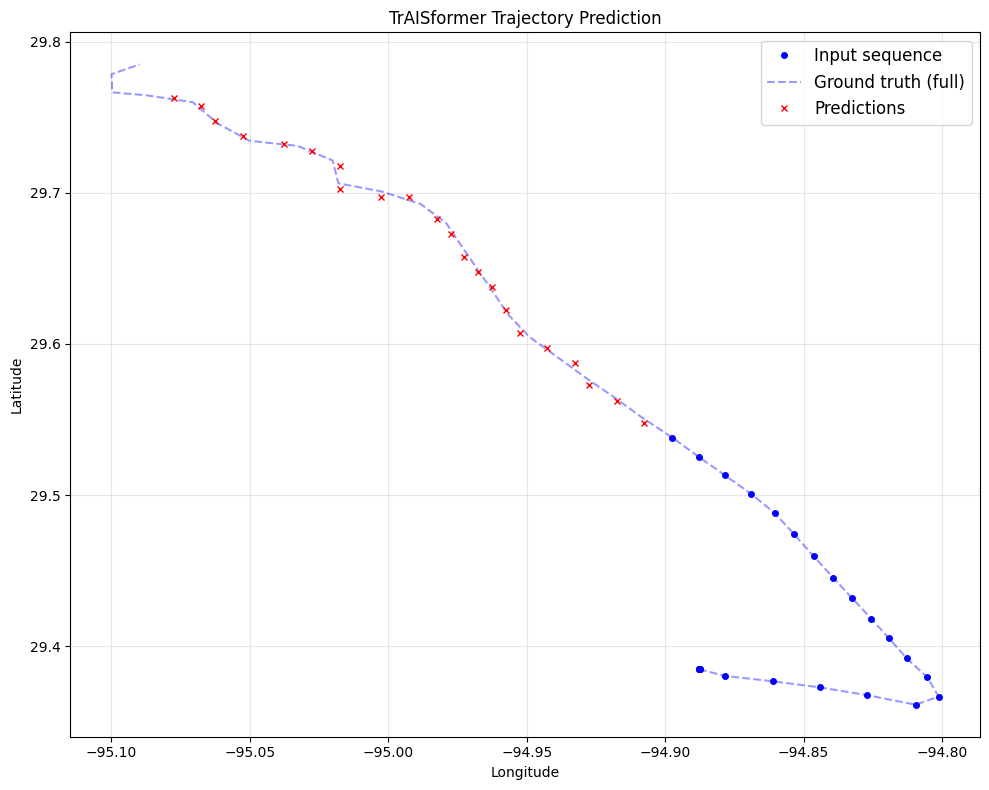

In [8]:
# Do inference
init_seqlen = 24
input_seq = tensor[0] # the original tensor
init_seq = tensor[:, :init_seqlen, :]  # (1, init_seqlen, 4) the input to the traisformer
max_seqlen = len(tensor[0])
traisformer.eval()
with torch.no_grad():
    pred_seq = sample(model = traisformer,
                      seqs = init_seq,
                      steps = max_seqlen - init_seqlen,
                      sample=True)  # (1, pred_seqlen, 4)

preds_np = pred_seq.detach().cpu().numpy().squeeze(0)  # (max_seqlen, 4)
inputs_np = input_seq.detach().cpu().numpy() # (max_seqlen, 4)

# convert normalized back to lat/lon
lat_min, lat_max = 20, 60
lon_min, lon_max = -160, -60
max_sog = 30
max_cog = 360

def denormalize_coordinates(coordinates:np.ndarray) -> np.ndarray:
    lat = coordinates[:, 0] * (lat_max - lat_min) + lat_min
    lon = coordinates[:, 1] * (lon_max - lon_min) + lon_min
    sog = coordinates[:, 2] * max_sog  # speed over ground
    cog = coordinates[:, 3] * max_cog  # course over ground
    return np.column_stack((lat, lon, sog, cog))

preds_np = denormalize_coordinates(preds_np)
inputs_np = denormalize_coordinates(inputs_np)

# visualize the results
plt.figure(figsize=(10, 8))
# plt.plot(inputs_np[:init_seqlen, 1], inputs_np[:init_seqlen, 0], color='green', linewidth=2, label='Input sequence')
plt.plot(inputs_np[:init_seqlen, 1], inputs_np[:init_seqlen, 0], "o", markersize=4, color='blue', label = 'Input sequence')
plt.plot(inputs_np[:max_seqlen, 1], inputs_np[:max_seqlen, 0], linestyle="--", color='blue', alpha=0.4, label='Ground truth (full)')
plt.plot(preds_np[init_seqlen:, 1], preds_np[init_seqlen:, 0], "x", markersize=5, color='red', label='Predictions')

plt.title('TrAISformer Trajectory Prediction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

## 2 Neighbor Detection
This portion of the project uses the predictions from the trAISformer and tries to identify neighboring vessels

In [9]:
# Load predictions to be used in neighbor detection
# This loads the trAISformer outputs for all vessels in the test set

all_preds_path = '/home/chucey/GQP/TrAISformer/results/us_continent_2024-pos-pos_vicinity-10-40-blur-True-False-2-1.0-data_size-8000-20000-60-360-embd_size-256-256-128-128-head-8-8-bs-32-lr-0.0006-seqlen-36-96-epochs-50/predictions_out/traisformer_preds_test.csv'

df_all = pd.read_csv(all_preds_path)

# Find neighbors for the target vessel
def identify_neighbors(mmsi: int, dist: float = 3.0, time_tolerance_sec: float = 120) -> pd.DataFrame:

    df_target = df_all[df_all["mmsi"] == mmsi]
    df_others = df_all[df_all["mmsi"] != mmsi]

    neighbors = find_neighbors_for_target(df_target = df_target,
                                          df_others = df_others,
                                          radius_km= dist * 1.852,  # convert nm to km
                                          time_tolerance_sec=time_tolerance_sec)

    neighbors.dropna(inplace=True)
    neighbors["neighbor_dist_km"] = neighbors["neighbor_dist_km"] / 1.852  # convert km to nm
    neighbors = neighbors.rename(columns={"neighbor_dist_km": "neighbor_dist_nm"})

    return neighbors

target_mmsi = data[1000]['mmsi'] # example target vessel MMSI
neighbors_df = identify_neighbors(target_mmsi, dist=3.0, time_tolerance_sec=120)
neighbors_df.head()

,target_mmsi,t_unix,lat_deg,lon_deg,neighbor_mmsi,neighbor_dist_nm,n_neighbors
4,538009560,1708857601,39.024929,-75.152275,311001084.0,1.353627,1
11,538009560,1708861801,39.306820,-75.387543,255806103.0,0.461080,1
16,538009560,1708864801,39.481201,-75.562675,636018713.0,2.353880,1
17,538009560,1708865401,39.525452,-75.548454,636018713.0,2.345577,1
18,538009560,1708866001,39.563450,-75.545837,366966210.0,1.438850,1


In [10]:
df_all.head()

,mmsi,t_unix,lat_deg,lon_deg,sog_knots,cog_deg
0,368062150,1708996545,29.380299,-94.878349,5.342857,98.700005
1,368062150,1708997145,29.376774,-94.861198,5.527535,104.162338
2,368062150,1708997745,29.372681,-94.843987,5.599999,102.599991
3,368062150,1708998345,29.367580,-94.827034,5.700000,117.954285
4,368062150,1708998945,29.361240,-94.809509,6.050000,100.000008


In [ ]:
# get the target vessel trajectory
target_vessel_trajectory = df_all[df_all['mmsi'] == target_mmsi]

# get the neighboring vessel trajectories
neighboring_vessels = neighbors_df['neighbor_mmsi'].unique()
neighbor_trajectories = []
for neighbor_mmsi in neighboring_vessels:
    traj = df_all[df_all['mmsi'] == neighbor_mmsi]
    neighbor_trajectories.append((neighbor_mmsi, traj))
neighbor_indices = (0,14) # these two look nice :)
neighbor_trajectories = [neighbor_trajectories[i] for i in neighbor_indices]

2

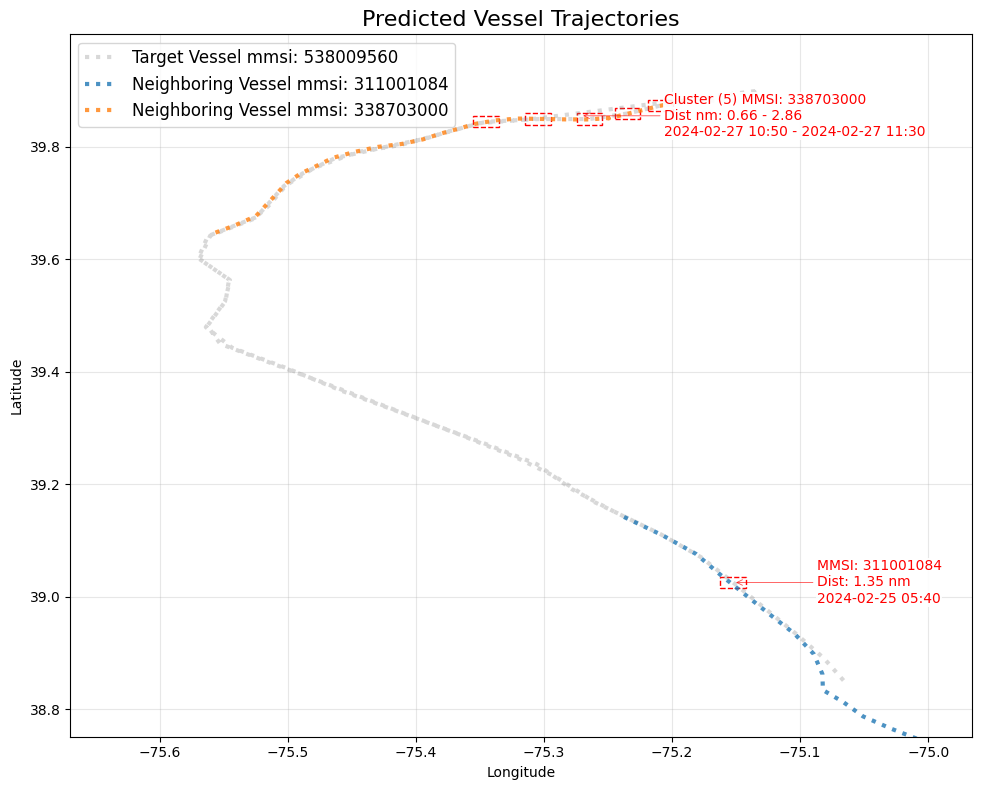

In [12]:
# Plot vessel trajectories with grouped annotations to avoid collisions
# Strategy: collect all annotation items, cluster nearby items in display space,
# summarize each cluster into a single annotation, and place summary annotations
# using a renderer-aware on-axis candidate search to avoid plotted points and other labels.

from datetime import datetime
import numpy as np
import math
import matplotlib.transforms as mtransforms

plt.figure(figsize=(10, 8))
ax = plt.gca()
fig = plt.gcf()

# Plot target trajectory
target_traj = target_vessel_trajectory[['lat_deg', 'lon_deg']].to_numpy()
ax.plot(target_traj[:, 1], target_traj[:, 0], color='grey', linestyle='dotted', linewidth=3, alpha=0.3, label=f'Target Vessel mmsi: {target_mmsi}')

# draw an initial legend so we can reserve its bbox
placed_ann_bboxes = []
handles, labels = ax.get_legend_handles_labels()
if handles:
    legend = ax.legend(handles, labels, loc='best', fontsize=12)
    fig.canvas.draw()
    try:
        renderer = fig.canvas.get_renderer()
        legend_bb = legend.get_window_extent(renderer=renderer)
        legend_bb_exp = mtransforms.Bbox.from_bounds(legend_bb.x0 - 6, legend_bb.y0 - 6, legend_bb.width + 12, legend_bb.height + 12)
        placed_ann_bboxes.append(legend_bb_exp)
    except Exception:
        pass

# plot neighbor trajectories (but defer annotations until clustering)
ann_items = []  # list of dicts: {'xy':(lon,lat),'text':str, 'mmsi':..., 'row': row}
for neighbor_mmsi, neighbor_traj_df in neighbor_trajectories[:8]:
    neighbor_traj = neighbor_traj_df[neighbor_traj_df['t_unix'].between(target_vessel_trajectory['t_unix'].min() - 300, target_vessel_trajectory['t_unix'].max() + 300)][['lat_deg', 'lon_deg']].to_numpy()
    if neighbor_traj.size:
        ax.plot(neighbor_traj[:, 1], neighbor_traj[:, 0], linestyle=':', linewidth=3, alpha=0.8, label=f'Neighboring Vessel mmsi: {int(neighbor_mmsi)}')

    subset_neighbors = neighbors_df[neighbors_df['neighbor_mmsi'] == neighbor_mmsi]
    for _, row in subset_neighbors.iterrows():
        # keep rectangle patch unchanged
        offset = 0.01
        rect = patches.Rectangle((row['lon_deg'] - offset, row['lat_deg'] - offset), 2*offset, 2*offset,
                                 linewidth=1, edgecolor='r', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ann_text = f"MMSI: {int(neighbor_mmsi)}\nDist: {row['neighbor_dist_nm']:.2f} nm\n{datetime.fromtimestamp(row['t_unix']).strftime('%Y-%m-%d %H:%M')}"
        ann_items.append({'xy':(row['lon_deg'], row['lat_deg']), 'text': ann_text, 'mmsi': int(neighbor_mmsi), 'row': row})

# If no annotation items, just finish
if not ann_items:
    ax.set_title('Vessel Trajectories', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
else:
    # renderer ready
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # transform annotation data points to display coords for clustering
    data_coords = np.array([item['xy'] for item in ann_items])  # (lon, lat)
    disp_coords = ax.transData.transform(data_coords)  # (x_pix, y_pix)

    # simple clustering in pixel space: agglomerative via BFS using eps
    def cluster_pixels(points, eps_pixels=45.0):
        n = len(points)
        assigned = np.full(n, -1, dtype=int)
        clusters = []
        cid = 0
        for i in range(n):
            if assigned[i] != -1:
                continue
            # BFS
            stack = [i]
            assigned[i] = cid
            members = [i]
            while stack:
                u = stack.pop()
                d = np.linalg.norm(points - points[u], axis=1)
                neigh = np.where((d <= eps_pixels) & (assigned == -1))[0]
                for v in neigh:
                    assigned[v] = cid
                    stack.append(v)
                    members.append(v)
            clusters.append(members)
            cid += 1
        return clusters

    clusters = cluster_pixels(disp_coords, eps_pixels=45.0)

    # prepare plotted points for collision checks (target + neighbor points)
    try:
        pts_target_disp = ax.transData.transform(target_traj[:, [1, 0]])
    except Exception:
        pts_target_disp = np.empty((0, 2))

    # include neighbor trajectories' points as well
    all_neighbor_pts = []
    for neighbor_mmsi, neighbor_traj_df in neighbor_trajectories[:8]:
        arr = neighbor_traj_df[['lat_deg', 'lon_deg']].to_numpy()
        if arr.size:
            all_neighbor_pts.append(arr)
    if all_neighbor_pts:
        all_neighbor_pts = np.vstack(all_neighbor_pts)
        try:
            pts_neigh_disp = ax.transData.transform(all_neighbor_pts[:, [1, 0]])
            if pts_target_disp.size:
                pts_all_disp = np.vstack((pts_target_disp, pts_neigh_disp))
            else:
                pts_all_disp = pts_neigh_disp
        except Exception:
            pts_all_disp = pts_target_disp.copy()
    else:
        pts_all_disp = pts_target_disp.copy()

    # candidate generation helper
    dpi = fig.dpi
    radii = [20, 40, 60, 90, 130]
    angles = [8, 12, 12, 16, 20]
    min_sep_pixels = 22

    placed_ann_bboxes = placed_ann_bboxes or []

    # function to select placement for a given data point and text
    def place_annotation(xy_data, ann_text):
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        ax_bbox = ax.get_window_extent(renderer=renderer)
        base_disp = ax.transData.transform(xy_data)

        candidate_offsets = []
        for r, n_ang in zip(radii, angles):
            for k in range(n_ang):
                theta = 2 * math.pi * k / n_ang
                dx_pix = r * math.cos(theta)
                dy_pix = r * math.sin(theta)
                dx_pts = dx_pix * 72.0 / dpi
                dy_pts = dy_pix * 72.0 / dpi
                candidate_offsets.append((dx_pts, dy_pts))
        smalls = [ (12*72.0/dpi, 0), (-12*72.0/dpi, 0), (0, 12*72.0/dpi), (0, -12*72.0/dpi) ]
        candidate_offsets = smalls + candidate_offsets

        best_score = -1.0
        best_offset = None
        best_bb = None

        for off_pts in candidate_offsets:
            tmp = ax.annotate(ann_text, xy=xy_data, xytext=off_pts, textcoords='offset points', ha='left', va='center', fontsize=8,
                              color='red', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=0.6),
                              arrowprops=dict(arrowstyle='->', color='red', linewidth=0.6, alpha=0.7), annotation_clip=False)
            bb = tmp.get_window_extent(renderer=renderer)
            # must be fully on-plot
            if not ((bb.x0 >= ax_bbox.x0) and (bb.x1 <= ax_bbox.x1) and (bb.y0 >= ax_bbox.y0) and (bb.y1 <= ax_bbox.y1)):
                tmp.remove()
                continue
            bb_exp = mtransforms.Bbox.from_bounds(bb.x0 - min_sep_pixels, bb.y0 - min_sep_pixels, bb.width + 2*min_sep_pixels, bb.height + 2*min_sep_pixels)

            # conflict with plotted points
            conflict = False
            if pts_all_disp.size:
                inside_mask = (pts_all_disp[:, 0] >= bb_exp.x0) & (pts_all_disp[:, 0] <= bb_exp.x1) & (pts_all_disp[:, 1] >= bb_exp.y0) & (pts_all_disp[:, 1] <= bb_exp.y1)
                if inside_mask.any():
                    conflict = True
            # conflict with existing placed labels
            if not conflict:
                for other_bb in placed_ann_bboxes:
                    if bb_exp.overlaps(other_bb):
                        conflict = True
                        break
            if conflict:
                tmp.remove()
                continue

            # scoring: distance to nearest point or existing label
            bb_center = np.array([bb.x0 + bb.width/2.0, bb.y0 + bb.height/2.0])
            if pts_all_disp.size:
                d_pts = np.linalg.norm(pts_all_disp - bb_center.reshape(1,2), axis=1)
                min_d_pts = np.min(d_pts)
            else:
                min_d_pts = 1e6
            if placed_ann_bboxes:
                centers = np.array([[b.x0 + b.width/2.0, b.y0 + b.height/2.0] for b in placed_ann_bboxes])
                d_anns = np.linalg.norm(centers - bb_center.reshape(1,2), axis=1)
                min_d_anns = np.min(d_anns)
            else:
                min_d_anns = 1e6
            score = min(min_d_pts, min_d_anns)
            rad = math.hypot(off_pts[0]*dpi/72.0, off_pts[1]*dpi/72.0)
            score_adj = score - 0.01 * rad
            if score_adj > best_score:
                best_score = score_adj
                best_offset = off_pts
                best_bb = bb_exp
            tmp.remove()

        # fallback offsets
        if best_offset is None:
            for fo in [(60,0), (-60,0), (0,60), (0,-60)]:
                tmp = ax.annotate(ann_text, xy=xy_data, xytext=fo, textcoords='offset points', ha='left', va='center', fontsize=8,
                                  color='red', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=0.6),
                                  arrowprops=dict(arrowstyle='->', color='red', linewidth=0.6, alpha=0.7), annotation_clip=False)
                bb = tmp.get_window_extent(renderer=renderer)
                if (bb.x0 >= ax_bbox.x0) and (bb.x1 <= ax_bbox.x1) and (bb.y0 >= ax_bbox.y0) and (bb.y1 <= ax_bbox.y1):
                    best_offset = fo
                    best_bb = mtransforms.Bbox.from_bounds(bb.x0 - min_sep_pixels, bb.y0 - min_sep_pixels, bb.width + 2*min_sep_pixels, bb.height + 2*min_sep_pixels)
                    tmp.remove()
                    break
                tmp.remove()

        # final fallback: place very small offset
        if best_offset is None:
            best_offset = (25, 0)
            final = ax.annotate(ann_text, xy=xy_data, xytext=best_offset, textcoords='offset points', ha='left', va='center', fontsize=8,
                                 color='red', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=0.6),
                                 arrowprops=dict(arrowstyle='->', color='red', linewidth=0.6, alpha=0.7), annotation_clip=False)
            fig.canvas.draw()
            renderer = fig.canvas.get_renderer()
            bb_final = final.get_window_extent(renderer=renderer)
            bb_final_exp = mtransforms.Bbox.from_bounds(bb_final.x0 - min_sep_pixels, bb_final.y0 - min_sep_pixels, bb_final.width + 2*min_sep_pixels, bb_final.height + 2*min_sep_pixels)
            placed_ann_bboxes.append(bb_final_exp)
            return final

        # place chosen annotation
        final = ax.annotate(ann_text, xy=xy_data, xytext=best_offset, textcoords='offset points', ha='left', va='center', fontsize=10,
                            color='red', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=0.6),
                            arrowprops=dict(arrowstyle='->', color='red', linewidth=0.6, alpha=0.7), annotation_clip=False)
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        bb_final = final.get_window_extent(renderer=renderer)
        bb_final_exp = mtransforms.Bbox.from_bounds(bb_final.x0 - min_sep_pixels, bb_final.y0 - min_sep_pixels, bb_final.width + 2*min_sep_pixels, bb_final.height + 2*min_sep_pixels)
        placed_ann_bboxes.append(bb_final_exp)
        return final

    # place one annotation per cluster (aggregate text for clusters with multiple items)
    for members in clusters:
        if len(members) == 1:
            idx = members[0]
            item = ann_items[idx]
            place_annotation(item['xy'], item['text'])
        else:
            # summarize cluster
            items = [ann_items[i] for i in members]
            mm = list({it['mmsi'] for it in items})
            cnt = len(items)
            # choose centroid in data coords
            coords = np.array([it['xy'] for it in items])
            centroid = (coords[:,0].mean(), coords[:,1].mean())
            # summarize distances (min, max)
            dists = [it['row']['neighbor_dist_nm'] for it in items]
            # summarize time range
            times = [datetime.fromtimestamp(it['row']['t_unix']) for it in items]
            tmin = min(times).strftime('%Y-%m-%d %H:%M')
            tmax = max(times).strftime('%Y-%m-%d %H:%M')
            txt = f"Cluster ({cnt}) MMSI: {','.join(map(str, mm))}\nDist nm: {min(dists):.2f} - {max(dists):.2f}\n{tmin} - {tmax}"
            place_annotation(centroid, txt)

    # final plot formatting
    x_min, x_max = target_vessel_trajectory['lon_deg'].min() - 0.1, target_vessel_trajectory['lon_deg'].max() + 0.1
    y_min, y_max = target_vessel_trajectory['lat_deg'].min() - 0.1, target_vessel_trajectory['lat_deg'].max() + 0.1
    ax.set_title('Predicted Vessel Trajectories', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True, alpha=0.3)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='best', fontsize=12)
    plt.tight_layout()

## 3 Anomaly Detection
This portion of project highlights anomaly detection. Here, we use anomaly classifier to detect whether the trajectory of the target vessel and its neighbors are anomalous.

To do this, we will pass the trajectories through a hybrid GRU - CNN network to classify a trajectory as either:
* class 0: normal
* class 1: normal
* class -1: anomaly 

In [13]:
# load the model for anomaly detection
anomaly_model_path = '/home/chucey/GQP/TrAISformer/dbscan_model/gru_fcnn_dbscan_model.pkl'
with open(anomaly_model_path, 'rb') as f:
    anomaly_classifier = pickle.load(f)

In [14]:
def prepare_anomaly_input(df: pd.DataFrame) -> np.ndarray:
    # Extract relevant features: lat, lon, sog, cog
    arr = df[['lat_deg', 'lon_deg', 'sog_knots', 'cog_deg']].to_numpy()
    # normalize array
  
    arr[:, 0] = (arr[:, 0] - lat_min) / (lat_max - lat_min)
    arr[:, 1] = (arr[:, 1] - lon_min) / (lon_max - lon_min)
    arr[:, 2] = arr[:, 2] / max_sog
    arr[:, 3] = arr[:, 3] / max_cog
    # pad or truncate to fixed length 
    fixed_length = 144  # determined during dbscan model training
    if arr.shape[0] < fixed_length:
        padding = np.zeros((fixed_length - arr.shape[0], arr.shape[1]))
        arr = np.vstack((arr, padding))
    else:
        arr = arr[:fixed_length, :]

    return np.expand_dims(arr, axis=0)  # add batch dimension

In [15]:
test = prepare_anomaly_input(target_vessel_trajectory)
type(test), test.shape  # should be (1, fixed_length, 4)

(numpy.ndarray, (1, 144, 4))

In [16]:
out = anomaly_classifier.predict(test)
out  # class label: 0 (normal), 1 (normal), -1 (anomaly)

array([0])

In [17]:
# make prediction
def make_anomaly_prediction(df: pd.DataFrame, model: GRUFCNNClassifier = anomaly_classifier) -> int:
    input_data = prepare_anomaly_input(df)
    prediction = model.predict(input_data)
    return prediction.item()  # return class label

In [18]:
def plot_anomaly_detection(ax, mmsi: int, traj_df: pd.DataFrame, model: GRUFCNNClassifier) -> None:
    """
    Plot trajectory colored by speed, with title indicating anomaly detection result.
    """
    cluster_label = make_anomaly_prediction(traj_df)
    color = 'green' if cluster_label != -1 else 'red'

    sc = ax.scatter(traj_df['lon_deg'], traj_df['lat_deg'], c=traj_df['sog_knots'], cmap='viridis', s=25)
    ax.plot(traj_df['lon_deg'], traj_df['lat_deg'], linestyle='--', linewidth=1, alpha=0.3, color='grey')
    ax.set_title(f'MMSI: {int(mmsi)}\nPredicted Cluster: {cluster_label}\nDescription: {"Normal" if cluster_label != -1 else "Anomaly"}', fontsize=14, color=color)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Speed Over Ground (knots)', fontsize=14)
    cbar.ax.tick_params(labelsize=14)

In [ ]:
traj_list = [(target_mmsi, target_vessel_trajectory)] + neighbor_trajectories

In [20]:
# save traj_list to pickle file
with open('traj_list.pkl', 'wb') as f:
    pickle.dump(traj_list, f)

## Behavior Detection
Here we characterize the behaviors of vessels in transit

In [21]:
# -----------------------------------------------------------
# 1.  Behavior label mappings (you already defined these)
# -----------------------------------------------------------

kmeans_cluster_to_behavior = {
    0: "cruise_fast_steady",
    1: "stopped_static",
    2: "loiter_turning",
    3: "transit_accelerating",
    4: "transit_decelerating",
    5: "slow_cruise_loiter",
}

hc_cluster_to_behavior = {
    0: "loiter_turning",
    1: "transit_decelerating",
    2: "transit_accelerating",
    3: "cruise_fast_steady",
    4: "stopped_static",
    5: "slow_cruise_loiter",
}

gmm_cluster_to_behavior = {
    0: "cruise_fast_steady",
    1: "stopped_static",
    2: "loiter_sharp_turns",
    3: "transit_accelerating_maneuver",
    4: "loiter_decelerating_maneuver",
    5: "slow_cruise_steady",
    6: "cruise_decelerating_turning",
}


# -----------------------------------------------------------
# 2.  Helper: wrap angle differences in "revolutions" [-0.5, 0.5]
# -----------------------------------------------------------

def wrap_angle_unit(d_cog: np.ndarray) -> np.ndarray:
    """
    d_cog is difference of normalized COG (0..1). We want the shortest
    wrap-around difference in range [-0.5, 0.5] (i.e., -180..180 deg / 360).
    """
    return ((d_cog + 0.5) % 1.0) - 0.5


# -----------------------------------------------------------
# 3.  Compute 7 window features from a raw (UN-normalized) window DF
#     (this reproduces your original normalized-feature logic)
# -----------------------------------------------------------

def compute_window_features(win_df: pd.DataFrame) -> Dict[str, float]:
    """
    win_df: slice of one trajectory, original units:
      columns must include ['sog_knots','cog_deg'].
    Returns dict with the 7 behaviour features, using the SAME
    normalization / thresholds as your clustering pipeline.
    """
    # ---- constants (must match your training pipeline) ----
    SPEED_MAX = 30.0                 # knots -> sog_norm in [0,1]
    STOP_KNOTS = 0.5
    SLOW_KNOTS = 5.0
    STOP_THRESH_NORM = STOP_KNOTS / SPEED_MAX
    SLOW_THRESH_NORM = SLOW_KNOTS / SPEED_MAX

    # ---- speed features (use normalized SOG 0..1) ----
    sog_knots = win_df["sog_knots"].astype(float).to_numpy()
    sog_norm = np.clip(sog_knots / SPEED_MAX, 0.0, 1.0)

    mean_sog = float(sog_norm.mean())
    frac_stopped = float((sog_norm < STOP_THRESH_NORM).mean())
    frac_slow = float((sog_norm < SLOW_THRESH_NORM).mean())

    # ---- turning features using normalized COG 0..1 ----
    cog_deg = win_df["cog_deg"].astype(float).to_numpy()
    cog_norm = (cog_deg % 360.0) / 360.0

    if cog_norm.size > 1:
        d_cog = np.diff(cog_norm)
        d_cog = wrap_angle_unit(d_cog)  # in "revolutions"

        # sampling is at 10-min resolution in your preprocessing
        dt_min = 10.0
        turnrate = np.abs(d_cog) / dt_min  # revolutions per minute

        mean_abs_turnrate = float(turnrate.mean())
        cog_spike = float(np.max(np.abs(d_cog)))  # biggest normalized jump per step
    else:
        mean_abs_turnrate = 0.0
        cog_spike = 0.0

    # ---- acceleration features from normalized SOG ----
    if sog_norm.size > 1:
        dt_hr = 10.0 / 60.0  # 10 minutes in hours
        accel = np.diff(sog_norm) / dt_hr  # norm units per hour

        mean_accel = float(accel.mean())
        max_abs_accel = float(np.max(np.abs(accel)))
    else:
        mean_accel = 0.0
        max_abs_accel = 0.0

    return {
        "mean_sog_30min": mean_sog,
        "frac_stopped_30min": frac_stopped,
        "frac_slow_30min": frac_slow,
        "mean_abs_turnrate_norm_per_min_30min": mean_abs_turnrate,
        "cog_spike_norm_30min": cog_spike,
        "mean_accel_norm_per_hr_30min": mean_accel,
        "max_abs_accel_norm_per_hr_30min": max_abs_accel,
    }


# -----------------------------------------------------------
# 4.  Build windows + features for one trajectory DF
# -----------------------------------------------------------

def build_windows_for_traj(traj_df: pd.DataFrame,
                           traj_index: int,
                           window_minutes: int = 30,
                           step_minutes: int = 10) -> List[Dict[str, Any]]:
    """
    Non-overlapping or sliding windows along t_unix.
    Assumes traj_df sorted by t_unix.
    Returns list of dicts, each containing features + metadata.
    """
    traj_df = traj_df.sort_values("t_unix").reset_index(drop=True)
    t_vals = traj_df["t_unix"].to_numpy().astype(int)

    if len(t_vals) == 0:
        return []

    w_sec = window_minutes * 60
    step_sec = step_minutes * 60

    t_start = t_vals[0]
    t_end_max = t_vals[-1]

    mmsi = int(traj_df["mmsi"].iloc[0])

    windows: List[Dict[str, Any]] = []
    window_id = 0

    while t_start + w_sec <= t_end_max:
        t_end = t_start + w_sec
        mask = (t_vals >= t_start) & (t_vals < t_end)
        win_df = traj_df.loc[mask]

        # Need at least 2 points to compute diffs
        if len(win_df) >= 2:
            feats = compute_window_features(win_df)

            feats.update({
                "traj_window_id": window_id,
                "start_time_unix": int(t_start),
                "end_time_unix": int(t_end),
                "traj_index": traj_index,
                "traj_mmsi": mmsi,
                "lat_center_deg": float(win_df["lat_deg"].mean()),
                "lon_center_deg": float(win_df["lon_deg"].mean()),
            })

            windows.append(feats)
            window_id += 1

        t_start += step_sec

    return windows


# -----------------------------------------------------------
# 5.  Main pipeline function (this is what you call)
# -----------------------------------------------------------

# ---------- plotting helper: plot single vessel behaviors ----------
def plot_for_method(traj_windows_df: pd.DataFrame, mmsi, ax, output_plot_dir: str, method: str, cluster_col: str, behavior_col: str) -> None:
    """Plot per-vessel behaviour map and save PNGs."""
    os.makedirs(output_plot_dir, exist_ok=True)
    # for mmsi, df_vessel in traj_windows_df.groupby("traj_mmsi"):
    df_vessel = traj_windows_df[traj_windows_df['traj_mmsi'] == mmsi]
    # plt.figure(figsize=(6, 5))
    sc = ax.scatter(
        df_vessel["lon_center_deg"],
        df_vessel["lat_center_deg"],
        c=df_vessel[cluster_col],
        cmap="Set1",
        s=25,
    )
    ax.plot(
        df_vessel["lon_center_deg"],
        df_vessel["lat_center_deg"],
        linestyle="--",
        linewidth=1,
        alpha=0.3,
        color="grey",
    )
    ax.set_xlabel("Longitude", fontsize=14)
    ax.set_ylabel("Latitude", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f"MMSI {int(mmsi)}\n{method} behaviors", fontsize=16)

    # (cluster id -> behavior)
    behaviors = df_vessel[[cluster_col, behavior_col]].drop_duplicates()
    handles = []
    labels = []
    for cl, beh in zip(behaviors[cluster_col], behaviors[behavior_col]):
        handles.append(plt.Line2D([], [], color=sc.cmap(sc.norm(cl)), marker="o", linestyle="", markersize=6))
        labels.append(f"{cl}: {beh}")
    ax.legend(handles, labels, title="cluster: behavior", loc="best", fontsize=14, title_fontsize=16)
    ax.grid(True, alpha=0.3)

    # fname = os.path.join(output_plot_dir, f"{method}_mmsi_{int(mmsi)}.png")
    # plt.tight_layout()
        # plt.savefig(fname, dpi=200)
        # plt.close()
        # print(f"Saved {method} plot for MMSI {mmsi} -> {fname}")

def run_behavior_pipeline(traj_pkl_path: str,
                          centroids_excel_path: str = "centroids.xlsx",
                          output_csv: str = "traj_windows_with_behaviors.csv",
                          output_plot_dir: str = "behavior_plots") -> pd.DataFrame:
    """
    1. Load traj_list.pkl ([(mmsi, traj_df), ...])
    2. Build 30-min windows + features for ALL trajectories
    3. Load centroids for kmeans, HC, GMM from centroids.xlsx
       (sheets: 'kmeans_k6', 'hc_k6', 'gmm_k7')
    4. Assign clusters + behavior labels
    5. Save CSV and trajectory plots (lat vs lon colored by behavior)

    Returns the full windows DataFrame.
    """

    os.makedirs(output_plot_dir, exist_ok=True)

    # ---------- load trajectories ----------
    with open(traj_pkl_path, "rb") as f:
        traj_list: List[Tuple[int, pd.DataFrame]] = pickle.load(f)

    all_windows: List[Dict[str, Any]] = []
    for traj_idx, (mmsi, traj_df) in enumerate(traj_list):
        windows = build_windows_for_traj(traj_df, traj_idx)
        all_windows.extend(windows)

    traj_windows_df = pd.DataFrame(all_windows)
    if traj_windows_df.empty:
        print("No windows built. Check trajectories / time ranges.")
        return traj_windows_df

    # ---------- load centroids ----------
    kmeans_cent = (
        pd.read_excel(centroids_excel_path, sheet_name="kmeans_k6")
        .set_index("kmeans_k6_cluster")
    )
    hc_cent = (
        pd.read_excel(centroids_excel_path, sheet_name="hc_k6")
        .set_index("hc_k6_cluster")
    )
    gmm_cent = (
        pd.read_excel(centroids_excel_path, sheet_name="gmm_k7")
        .set_index("gmm_k7_cluster")
    )

    feature_cols = [
        "mean_sog_30min",
        "frac_stopped_30min",
        "frac_slow_30min",
        "mean_abs_turnrate_norm_per_min_30min",
        "cog_spike_norm_30min",
        "mean_accel_norm_per_hr_30min",
        "max_abs_accel_norm_per_hr_30min",
    ]

    X = traj_windows_df[feature_cols].to_numpy()

    def assign_by_centroids(cent_df: pd.DataFrame) -> np.ndarray:
        C = cent_df[feature_cols].to_numpy()  # (K,7)
        # Euclidean distance to each centroid
        # X: (N,7), C: (K,7) -> dist: (N,K)
        diff = X[:, None, :] - C[None, :, :]
        dist = np.linalg.norm(diff, axis=2)
        labels = np.argmin(dist, axis=1)
        return labels

    # ---------- cluster assignments ----------
    traj_windows_df["kmeans_k6_cluster"] = assign_by_centroids(kmeans_cent)
    traj_windows_df["hc_k6_cluster"] = assign_by_centroids(hc_cent)
    traj_windows_df["gmm_k7_cluster"] = assign_by_centroids(gmm_cent)

    # ---------- map to behavior labels ----------
    traj_windows_df["kmeans_behavior"] = traj_windows_df["kmeans_k6_cluster"].map(
        kmeans_cluster_to_behavior
    )
    traj_windows_df["hc_behavior"] = traj_windows_df["hc_k6_cluster"].map(
        hc_cluster_to_behavior
    )
    traj_windows_df["gmm_behavior"] = traj_windows_df["gmm_k7_cluster"].map(
        gmm_cluster_to_behavior
    )

    # ---------- save CSV ----------
    traj_windows_df.to_csv(output_csv, index=False)
    print(f"Saved window behaviors to: {output_csv}")

    # ---------- plotting: lat vs lon, colored by behavior ----------
    # Use the top-level helper to create per-method plots
    # plot_for_method(traj_windows_df, output_plot_dir, "kmeans", "kmeans_k6_cluster", "kmeans_behavior")
    # plot_for_method(traj_windows_df, output_plot_dir, "hc", "hc_k6_cluster", "hc_behavior")
    # plot_for_method(traj_windows_df, output_plot_dir, "gmm", "gmm_k7_cluster", "gmm_behavior")

    return traj_windows_df

In [22]:
traj_window_df = run_behavior_pipeline(
    traj_pkl_path="traj_list.pkl",
    centroids_excel_path="/home/chucey/GQP/TrAISformer/centroids.xlsx",
    output_csv="traj_windows_with_behaviors.csv",
    output_plot_dir="behavior_plots"
)

Saved window behaviors to: traj_windows_with_behaviors.csv


## Anomaly and Behavior Detection Together
Here we'll plot the trajectories of the target vessel and its neighbors. We'll plot Anomaly Detection on the left and Behavior Detection on the right 

In [23]:
nols = 2
nrows = math.ceil(len(traj_list) * 2 / nols)

# Visualize and plot anomaly detection results
fig, axes = plt.subplots(nrows, nols, figsize=(20, 30), dpi=500)
fig.suptitle(f'Vessel Trajectories with Predicted Anomaly Class (Left) and Behavior (Right)', fontsize=20, fontweight='bold', y=0.98)

for idx, (mmsi, traj_df) in enumerate(traj_list):
    
    col = 0
    row = idx 
    # ax = axes[row, col] if nrows > 1 else axes[col]
    plot_anomaly_detection(axes[row, col], mmsi, traj_df, anomaly_classifier)
    plot_for_method(traj_window_df,mmsi=mmsi, ax=axes[row, col + 1], output_plot_dir="behavior_plots", method="kmeans", cluster_col="kmeans_k6_cluster", behavior_col="kmeans_behavior")

plt.subplots_adjust(hspace=0.2, wspace=0.2, top=0.93)